[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [255 255 255]
  [255 255 255]
  [  0 255   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0 255]
  [  0   0   0]]

 [[  0   0   0]
  [255 255 255]
  [255 255 255]
  [255   0   0]
  [  0   0   0]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


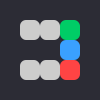

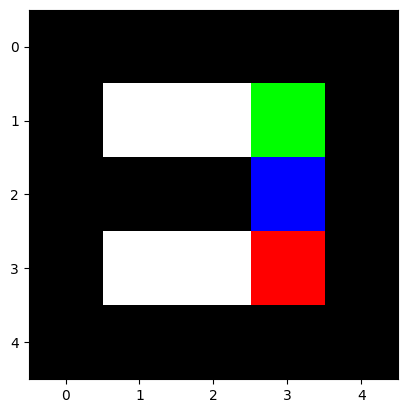

In [3]:
import io

import numpy as np
from IPython.display import SVG, display


def render_maze_fancy_svg(pixel_grid: np.ndarray) -> SVG:
	"""Render the pixel grid as an SVG with pill-style cells."""
	h, w, _ = pixel_grid.shape
	cell_size = 20
	radius = 6

	svg_buffer = io.StringIO()
	svg_buffer.write(
		f'<svg width="{w * cell_size}" height="{h * cell_size}" '
		f'xmlns="http://www.w3.org/2000/svg" viewBox="0 0 {w * cell_size} {h * cell_size}">\n'
		'<rect width="100%" height="100%" fill="#2c2c35"/>\n'
	)

	color_map = {
		(0, 0, 0): "#2c2c35",  # wall
		(255, 255, 255): "#cccccc",  # open
		(0, 255, 0): "#00cc66",  # start
		(255, 0, 0): "#ff4444",  # end
		(0, 0, 255): "#3AA0FF",  # path
	}

	for y in range(h):
		for x in range(w):
			rgb = tuple(pixel_grid[y, x])
			hex_color = color_map.get(rgb)
			if hex_color is None:
				continue
			cx = x * cell_size
			cy = y * cell_size
			svg_buffer.write(
				f'<rect x="{cx}" y="{cy}" width="{cell_size}" height="{cell_size}" '
				f'rx="{radius}" ry="{radius}" fill="{hex_color}"/>\n'
			)

	svg_buffer.write("</svg>")
	svg_data = svg_buffer.getvalue()
	return SVG(svg_data)


import matplotlib.pyplot as plt

from maze_dataset import LatticeMazeGenerators, MazeDataset, MazeDatasetConfig

cfg = MazeDatasetConfig(
	name="test", grid_n=2, n_mazes=5, maze_ctor=LatticeMazeGenerators.gen_dfs
)
ds = MazeDataset.from_config(cfg)
pixels = ds[0].as_pixels()
print(pixels)
plt.imshow(pixels)

svg_output = render_maze_fancy_svg(pixels)
display(svg_output)

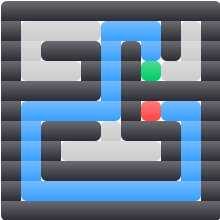

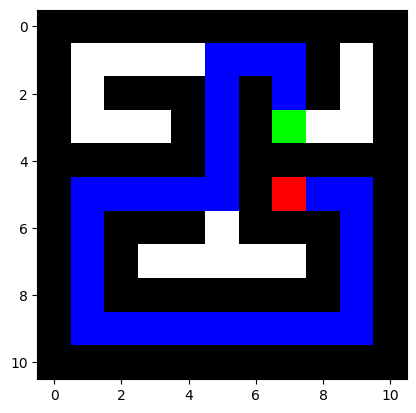

In [ ]:
import numpy as np
from IPython.display import SVG, display


def render_maze_fancy_svg_shaded(pixel_grid: np.ndarray) -> SVG:
	"""Render a pixel grid as an SVG with selective corner rounding,
	gradient shading, and drop shadows.

	Parameters
	----------
	  - pixel_grid: np.ndarray of shape (h, w, 3), a uint8 grid of RGB values.

	Returns
	-------
	  - An IPython.display.SVG object.

	"""
	h, w, _ = pixel_grid.shape
	cell_size = 20  # pixel size for each cell in the SVG
	radius = 6  # maximum corner radius

	# Map exact RGB tuples to base hex colors.
	color_map = {
		(0, 0, 0): "#2c2c35",  # wall
		(255, 255, 255): "#cccccc",  # open
		(0, 255, 0): "#00cc66",  # start
		(255, 0, 0): "#ff4444",  # end
		(0, 0, 255): "#3AA0FF",  # path
	}

	def lighten_color(hex_color: str, factor: float = 0.3) -> str:
		"""Return a lighter version of the hex color."""
		hex_color = hex_color.lstrip("#")
		r = int(hex_color[0:2], 16)
		g = int(hex_color[2:4], 16)
		b = int(hex_color[4:6], 16)
		r_new = int(r + (255 - r) * factor)
		g_new = int(g + (255 - g) * factor)
		b_new = int(b + (255 - b) * factor)
		return f"#{r_new:02x}{g_new:02x}{b_new:02x}"

	# Build gradients for each unique base color.
	unique_colors = set(color_map.values())
	gradients = {}
	for col in unique_colors:
		light = lighten_color(col)
		if col == "#2c2c35":
			grad_id = "grad-wall"
		elif col == "#cccccc":
			grad_id = "grad-open"
		elif col == "#00cc66":
			grad_id = "grad-start"
		elif col == "#ff4444":
			grad_id = "grad-end"
		elif col == "#3AA0FF":
			grad_id = "grad-path"
		else:
			grad_id = f"grad-{col.lstrip('#')}"
		gradients[col] = (grad_id, light)

	# Start building the SVG.
	svg_width = w * cell_size
	svg_height = h * cell_size
	svg_buffer = io.StringIO()
	svg_buffer.write(
		f'<svg width="{svg_width}" height="{svg_height}" xmlns="http://www.w3.org/2000/svg" viewBox="0 0 {svg_width} {svg_height}">\n'
	)

	# Define filters and gradients in <defs>.
	svg_buffer.write("<defs>\n")
	# Drop shadow filter.
	svg_buffer.write(
		'  <filter id="dropShadow" x="-20%" y="-20%" width="140%" height="140%">\n'
	)
	svg_buffer.write(
		'    <feGaussianBlur in="SourceAlpha" stdDeviation="1" result="blur"/>\n'
	)
	svg_buffer.write('    <feOffset in="blur" dx="1" dy="1" result="offsetBlur"/>\n')
	svg_buffer.write("    <feMerge>\n")
	svg_buffer.write('      <feMergeNode in="offsetBlur"/>\n')
	svg_buffer.write('      <feMergeNode in="SourceGraphic"/>\n')
	svg_buffer.write("    </feMerge>\n")
	svg_buffer.write("  </filter>\n")
	# Gradients.
	for col, (grad_id, light) in gradients.items():
		svg_buffer.write(
			f'  <linearGradient id="{grad_id}" x1="0%" y1="0%" x2="0%" y2="100%">\n'
		)
		svg_buffer.write(f'    <stop offset="0%" stop-color="{light}" />\n')
		svg_buffer.write(f'    <stop offset="100%" stop-color="{col}" />\n')
		svg_buffer.write("  </linearGradient>\n")
	svg_buffer.write("</defs>\n")

	# Helper: Check if neighbor at (ny, nx) has the same color.
	def same_color(ny: int, nx: int, col_tuple: tuple) -> bool:
		if ny < 0 or ny >= h or nx < 0 or nx >= w:
			return False
		return tuple(pixel_grid[ny, nx]) == col_tuple

	# For each cell, generate a custom path.
	for y in range(h):
		for x in range(w):
			col_tuple = tuple(pixel_grid[y, x])
			hex_color = color_map.get(col_tuple)
			if hex_color is None:
				continue
			# Determine whether each corner should be rounded.
			r_tl = (
				radius
				if (
					not same_color(y - 1, x, col_tuple)
					and not same_color(y, x - 1, col_tuple)
				)
				else 0
			)
			r_tr = (
				radius
				if (
					not same_color(y - 1, x, col_tuple)
					and not same_color(y, x + 1, col_tuple)
				)
				else 0
			)
			r_br = (
				radius
				if (
					not same_color(y + 1, x, col_tuple)
					and not same_color(y, x + 1, col_tuple)
				)
				else 0
			)
			r_bl = (
				radius
				if (
					not same_color(y + 1, x, col_tuple)
					and not same_color(y, x - 1, col_tuple)
				)
				else 0
			)

			X = x * cell_size
			Y = y * cell_size
			# Build the SVG path using independent corner radii.
			path_d = f"M {X + r_tl} {Y} "  # Start at top edge.
			path_d += f"H {X + cell_size - r_tr} "  # Top edge.
			if r_tr > 0:
				path_d += f"A {r_tr} {r_tr} 0 0 1 {X + cell_size} {Y + r_tr} "  # Top-right corner.
			else:
				path_d += f"L {X + cell_size} {Y} "
			path_d += f"V {Y + cell_size - r_br} "  # Right edge.
			if r_br > 0:
				path_d += f"A {r_br} {r_br} 0 0 1 {X + cell_size - r_br} {Y + cell_size} "  # Bottom-right.
			else:
				path_d += f"L {X + cell_size} {Y + cell_size} "
			path_d += f"H {X + r_bl} "  # Bottom edge.
			if r_bl > 0:
				path_d += (
					f"A {r_bl} {r_bl} 0 0 1 {X} {Y + cell_size - r_bl} "  # Bottom-left.
				)
			else:
				path_d += f"L {X} {Y + cell_size} "
			path_d += f"V {Y + r_tl} "  # Left edge.
			if r_tl > 0:
				path_d += f"A {r_tl} {r_tl} 0 0 1 {X + r_tl} {Y} "
			else:
				path_d += f"L {X} {Y} "
			path_d += "Z"

			# Use the gradient fill and drop shadow filter.
			grad_id = gradients[hex_color][0]
			svg_buffer.write(
				f'<path d="{path_d}" fill="url(#{grad_id})" filter="url(#dropShadow)"/>\n'
			)

	svg_buffer.write("</svg>")
	svg_data = svg_buffer.getvalue()
	return SVG(svg_data)


import matplotlib.pyplot as plt

from maze_dataset import LatticeMazeGenerators, MazeDataset, MazeDatasetConfig

cfg = MazeDatasetConfig(
	name="test", grid_n=5, n_mazes=5, maze_ctor=LatticeMazeGenerators.gen_dfs
)
ds = MazeDataset.from_config(cfg)
pixels = ds[0].as_pixels()
plt.imshow(pixels)

svg_shaded = render_maze_fancy_svg_shaded(pixels)
display(svg_shaded)

In [8]:
from typing import Literal
from xml.etree.ElementTree import Element, SubElement, tostring
from xml.dom.minidom import parseString
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt

# Known color map (excluding walls).
COLOR_MAP: dict[tuple[int, int, int], str] = {
	(255, 255, 255): "#f0f0f0",
	(0, 255, 0): "#4caf50",
	(255, 0, 0): "#f44336",
	(0, 0, 255): "#2196f3",
}

WALL_COLOR_HEX: str = "#222"  # (0,0,0) in hex
WALL_RGB: tuple[int, int, int] = (0, 0, 0)

# Offsets in the order [top, right, bottom, left]
_NEIGHBORS: np.ndarray = np.array(
	[
		[-1, 0],  # top
		[0, +1],  # right
		[+1, 0],  # bottom
		[0, -1],  # left
	],
	dtype=int,
)


def is_wall(y: int, x: int, grid: np.ndarray) -> bool:
	"""True if (y, x) is out of bounds or has the wall color."""
	h, w, _ = grid.shape
	if not (0 <= y < h and 0 <= x < w):
		return True
	return bool((grid[y, x] == WALL_RGB).all())


def create_tile_path(
	origin: tuple[float, float],
	tile_size: float,
	corner_radius: float,
	edges: tuple[bool, bool, bool, bool],
) -> str:
	"""
	Generate an SVG path for a tile at `origin` with side length `tile_size`.
	`edges` is (top, right, bottom, left) booleans, where True means that edge
	borders a wall/outside. If both edges meeting at a corner are True and
	corner_radius>0, we draw a rounded corner; else it's a sharp corner.

	Corner order (clockwise):
	  c0 = top-left
	  c1 = top-right
	  c2 = bottom-right
	  c3 = bottom-left

	edges = (top, right, bottom, left).
	  corner c0 is formed by edges top + left => edges[0] & edges[3]
	  corner c1 => top + right => edges[0] & edges[1]
	  corner c2 => right + bottom => edges[1] & edges[2]
	  corner c3 => bottom + left => edges[2] & edges[3]
	"""
	x0, y0 = origin
	top, right, bottom, left = edges

	# A corner is "exposed" if both adjoining edges are True
	c0_exposed: bool = top and left  # top-left
	c1_exposed: bool = top and right  # top-right
	c2_exposed: bool = right and bottom  # bottom-right
	c3_exposed: bool = bottom and left  # bottom-left

	# If corner_radius=0, arcs become straight lines.
	r: float = corner_radius

	# We'll construct the path in a standard top-left -> top-right -> bottom-right -> bottom-left order.
	path_cmds = []
	# Move to top-left corner, possibly offset if c0 is exposed
	# (meaning both top and left edges are external).
	start_x = x0 + (r if c0_exposed else 0)
	start_y = y0
	path_cmds.append(f"M {start_x},{start_y}")

	# === TOP edge to top-right corner
	end_x = x0 + tile_size - (r if c1_exposed else 0)
	end_y = y0
	path_cmds.append(f"L {end_x},{end_y}")
	# Arc if c1_exposed
	if c1_exposed and r > 0:
		path_cmds.append(f"A {r} {r} 0 0 1 {x0 + tile_size},{y0 + r}")

	# === RIGHT edge to bottom-right corner
	path_cmds.append(f"L {x0 + tile_size},{y0 + tile_size - (r if c2_exposed else 0)}")
	if c2_exposed and r > 0:
		path_cmds.append(f"A {r} {r} 0 0 1 {x0 + tile_size - r},{y0 + tile_size}")

	# === BOTTOM edge to bottom-left corner
	path_cmds.append(f"L {x0 + (r if c3_exposed else 0)},{y0 + tile_size}")
	if c3_exposed and r > 0:
		path_cmds.append(f"A {r} {r} 0 0 1 {x0},{y0 + tile_size - r}")

	# === LEFT edge back up to top-left corner
	path_cmds.append(f"L {x0},{y0 + (r if c0_exposed else 0)}")
	if c0_exposed and r > 0:
		path_cmds.append(f"A {r} {r} 0 0 1 {x0 + r},{y0}")

	path_cmds.append("Z")
	return " ".join(path_cmds)


def plot_svg_fancy(
	pixel_grid: np.ndarray,
	size: int = 40,
	corner_radius: float = 8.0,
	bounding_corner_radius: float = 20.0,
) -> str:
	"""
	Create an SVG with:
	  - A single rounded-square background (walls).
	  - Each non-wall cell is drawn via create_tile_path, with corner_radius controlling
	    whether corners are rounded. (Set corner_radius=0 for squares.)

	# Parameters:
	 - `pixel_grid : np.ndarray`
	   3D array of shape (h, w, 3) with RGB values
	 - `size : int`
	   Size (in px) of each grid cell
	 - `corner_radius : float`
	   Radius for rounding corners of each tile (0 => squares)
	 - `bounding_corner_radius : float`
	   Radius for rounding the outer bounding rectangle

	# Returns:
	 - `str`
	   A pretty-printed SVG string
	"""
	h, w, _ = pixel_grid.shape

	# Create the root <svg>
	svg = Element(
		"svg",
		xmlns="http://www.w3.org/2000/svg",
		width=str(w * size),
		height=str(h * size),
		viewBox=f"0 0 {w * size} {h * size}",
	)

	# Single rounded-square background for the walls
	SubElement(
		svg,
		"rect",
		{
			"x": "0",
			"y": "0",
			"width": str(w * size),
			"height": str(h * size),
			"fill": WALL_COLOR_HEX,
			"rx": str(bounding_corner_radius),
			"ry": str(bounding_corner_radius),
		},
	)

	for yy in range(h):
		for xx in range(w):
			rgb_tuple = tuple(pixel_grid[yy, xx])
			if rgb_tuple == WALL_RGB:
				# It's a wall => skip (already covered by background)
				continue

			fill_color: Optional[str] = COLOR_MAP.get(rgb_tuple, None)
			if fill_color is None:
				# Unknown color => skip or handle differently
				continue

			# Check which edges are "external" => next cell is wall
			# edges in the order (top, right, bottom, left)
			edges_bool = [
				is_wall(yy + dy, xx + dx, pixel_grid) for (dy, dx) in _NEIGHBORS
			]

			d_path = create_tile_path(
				origin=(xx * size, yy * size),
				tile_size=size,
				corner_radius=corner_radius,
				edges=tuple(edges_bool),
			)

			SubElement(
				svg,
				"path",
				{
					"d": d_path,
					"fill": fill_color,
					"stroke": "none",
				},
			)

	raw_svg = tostring(svg, encoding="unicode")
	pretty_svg = parseString(raw_svg).toprettyxml(indent="  ")
	return pretty_svg


arr: np.ndarray = np.array(
	[
		[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
		[
			[0, 0, 0],
			[255, 0, 0],
			[0, 0, 0],
			[255, 255, 255],
			[0, 0, 0],
			[255, 255, 255],
			[0, 0, 0],
		],
		[
			[0, 0, 0],
			[0, 0, 255],
			[0, 0, 0],
			[255, 255, 255],
			[0, 0, 0],
			[255, 255, 255],
			[0, 0, 0],
		],
		[
			[0, 0, 0],
			[0, 0, 255],
			[0, 0, 0],
			[255, 255, 255],
			[255, 255, 255],
			[0, 255, 0],
			[0, 0, 0],
		],
		[
			[0, 0, 0],
			[0, 0, 255],
			[0, 0, 0],
			[0, 0, 0],
			[0, 0, 0],
			[0, 0, 255],
			[0, 0, 0],
		],
		[
			[0, 0, 0],
			[0, 0, 255],
			[0, 0, 255],
			[0, 0, 255],
			[0, 0, 255],
			[0, 0, 255],
			[0, 0, 0],
		],
		[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]],
	],
	dtype=np.uint8,
)

svg_string: str = plot_svg_fancy(
	pixel_grid=arr,
	size=40,
	corner_radius=8.0,
	bounding_corner_radius=20.0,
)

# write the SVG string to a file
with open("maze.svg", "w") as f:
	f.write(svg_string)